# Problem Statement

Many people flock to NYC to visit the city that never sleeps. For for some this is not possible because it is very expensive. I have created a weekend guide that allows users to visit NYC on a budget. We will explore a model that recognizes popular landmarks and provides users with the history and some recommendations to do in the area.


# Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive

from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import ConfusionMatrixDisplay

np.random.seed(42)

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
image_arrays = []
image_path = 'drive/MyDrive/Capstone/Images/'

for folder in os.listdir(image_path):
    for file in os.listdir(image_path + folder):
        image_arrays.append(file)

print(f'There are {len(image_arrays)} pictures.')


There are 1810 pictures.


In [4]:
images_arrays = {}
images_path = 'drive/MyDrive/Capstone/Images/'

for folder in os.listdir(images_path):
    images_list = []
    for file in os.listdir(images_path + folder):
        images_list.append(file)
        images_arrays[folder] = len(images_list)

images_arrays


{'911Memorial': 175,
 'BrooklynBridge': 233,
 'Clock': 223,
 'EmpireStateBuilding': 236,
 'Gold': 144,
 'MetropolitanMuseum': 110,
 'PepsiCola': 240,
 'RooseveltIsland': 70,
 'StatueofLiberty': 193,
 'Vessel': 186}

Folder Name | Targeted Landmark | Number of Photos
-------------------|------------------ |------------------ 
911Memorial | 9/11 Memorial | 175
BrooklynBridge| Brooklyn Bridge | 233
EmpireStateBuilding | Empire State Building | 236
Clock| Grand Central Terminal | 223
MetropolitanMuseum | Metropolitan Museum | 110
PepsiCola| The Gantry Plaza State Park | 239
RooseveltIsland | Roosevelt Island | 70
Gold| Rockefeller Center| 144
StatueofLiberty| Statue of Liberty | 193
Vessel| Hudson Yards | 186

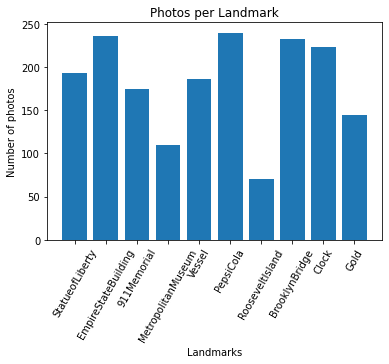

In [5]:
data = images_arrays
landmarks = list(data.keys())
photos = list(data.values())

plt.bar(range(len(data)), photos, tick_label=landmarks)
plt.xticks(rotation=60)
plt.title('Photos per Landmark')
plt.xlabel('Landmarks')
plt.ylabel('Number of photos');

# https://www.tutorialspoint.com/plot-a-bar-using-matplotlib-using-a-dictionary

**Intrepretation**: There is a lot of variance in the amount of photos per folder; PepsiCola has the most photos and RooseveltIsland has the least photos. 

# Feature Detection

In [6]:
def feature_detection(image_path, n, flags):
  """
  input image_path as a str
  """
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  orb = cv2.ORB_create(nfeatures=n)
  key_points, description = orb.detectAndCompute(img, None)

  key_points_img = cv2.drawKeypoints(img, key_points, img, flags=flags)

  cv2_imshow(key_points_img);


Oriented FAST and rotated BRIEF (ORB) is a feature detector that 

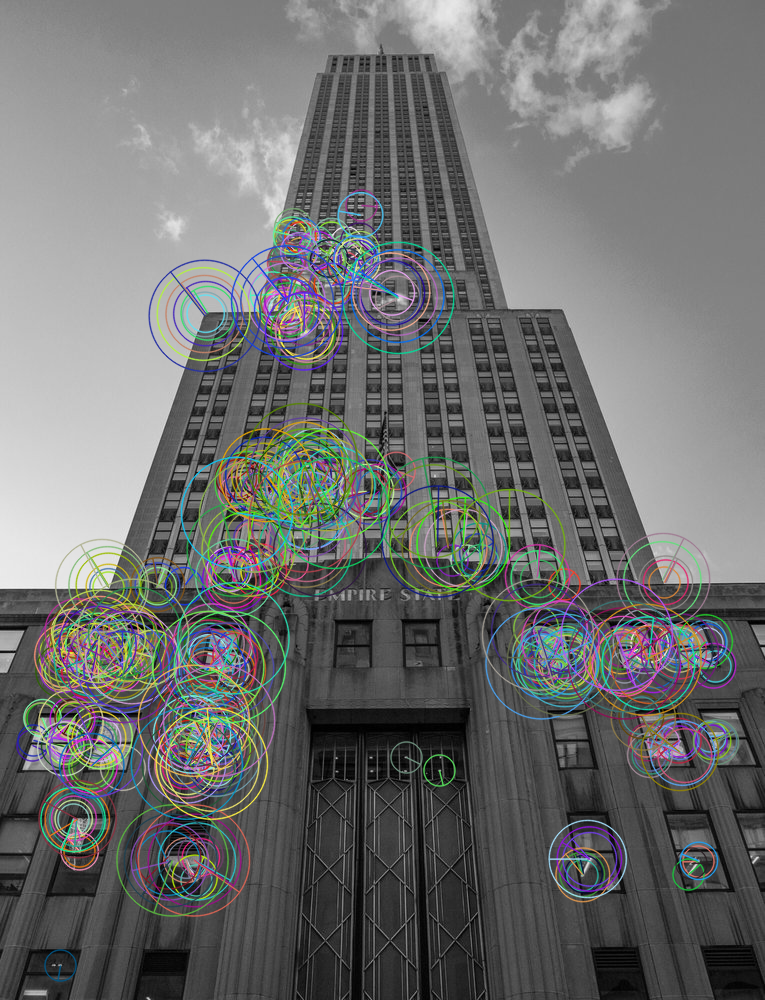

In [7]:
feature_detection('drive/MyDrive/Capstone/Images/EmpireStateBuilding/image (78).jpeg', 500, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

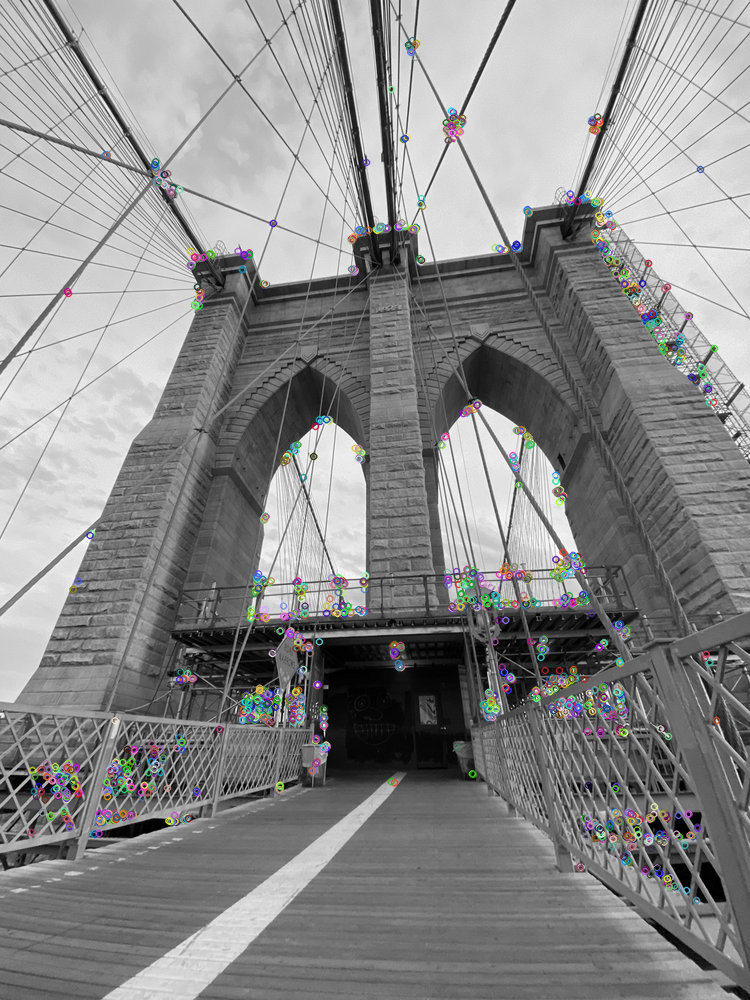

In [8]:
feature_detection('drive/MyDrive/Capstone/Images/BrooklynBridge/o-3.jpg', 2000, 0)

# Feature Matching

In [9]:
def feature_matching(image_path1, image_path2, n, n_matches):

  img1 = cv2.imread((image_path1), 0)
  img2 = cv2.imread((image_path2), 0)

  orb = cv2.ORB_create(nfeatures=n)
  key_point1, description1 = orb.detectAndCompute(img1, None)
  key_point2, description2 = orb.detectAndCompute(img2, None)

  brute_force = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = brute_force.match(description1, description2)
  matches = sorted(matches, key=lambda x: x.distance)

  match_img = cv2.drawMatches(img1, 
                            key_point1, 
                            img2, 
                            key_point2, 
                            matches[:n_matches], 
                            None)

  cv2_imshow(match_img)

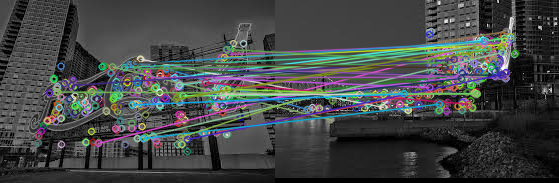

In [10]:
feature_matching('drive/MyDrive/Capstone/Images/PepsiCola/images (1).jpeg', 'drive/MyDrive/Capstone/Images/PepsiCola/images-1.jpeg', 500, 40)

# Model 1

In [11]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    'drive/MyDrive/Capstone/Images',
    target_size=(256,256),
    batch_size=32,
    subset='training',
    class_mode='binary'

)

test_gen = datagen.flow_from_directory(
    'drive/MyDrive/Capstone/Images',
    target_size=(256,256),
    batch_size=32,
    subset='validation',
    class_mode='binary'
)

Found 1451 images belonging to 10 classes.
Found 359 images belonging to 10 classes.


In [12]:
train_gen.class_indices

{'911Memorial': 0,
 'BrooklynBridge': 1,
 'Clock': 2,
 'EmpireStateBuilding': 3,
 'Gold': 4,
 'MetropolitanMuseum': 5,
 'PepsiCola': 6,
 'RooseveltIsland': 7,
 'StatueofLiberty': 8,
 'Vessel': 9}

In [13]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation = 'relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1)

history = model.fit(train_gen, 
                    validation_data=test_gen, 
                    epochs=20,
                    callbacks = early_stop
)

Epoch 1/20
46/46 [==============================] - 511s 11s/step - loss: 3.1936 - accuracy: 0.2378 - val_loss: 1.6627 - val_accuracy: 0.3900
Epoch 2/20
46/46 [==============================] - 19s 425ms/step - loss: 1.0497 - accuracy: 0.6465 - val_loss: 1.0474 - val_accuracy: 0.6267
Epoch 3/20
46/46 [==============================] - 19s 419ms/step - loss: 0.5019 - accuracy: 0.8498 - val_loss: 0.8885 - val_accuracy: 0.7298
Epoch 4/20
46/46 [==============================] - 20s 426ms/step - loss: 0.1391 - accuracy: 0.9614 - val_loss: 0.6794 - val_accuracy: 0.8022
Epoch 5/20
46/46 [==============================] - 20s 424ms/step - loss: 0.0196 - accuracy: 0.9972 - val_loss: 0.7045 - val_accuracy: 0.8022
Epoch 6/20
46/46 [==============================] - 19s 421ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.8243 - val_accuracy: 0.8189
Epoch 7/20
46/46 [==============================] - 19s 421ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7886 - val_accuracy: 0.8245


In [14]:
test_img = img_to_array(load_img('drive/MyDrive/Capstone/SampleImages/Mixed/images-8.jpeg'))
test_img = smart_resize(test_img, (256, 256))
test_img = np.expand_dims(test_img, axis=0)
model.predict(test_img).round()

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [15]:
train_gen.class_indices

{'911Memorial': 0,
 'BrooklynBridge': 1,
 'Clock': 2,
 'EmpireStateBuilding': 3,
 'Gold': 4,
 'MetropolitanMuseum': 5,
 'PepsiCola': 6,
 'RooseveltIsland': 7,
 'StatueofLiberty': 8,
 'Vessel': 9}

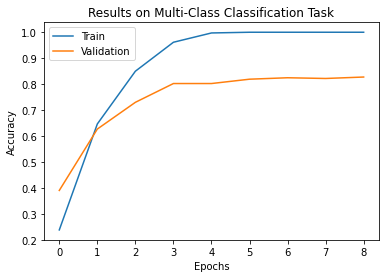

In [16]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Results on Multi-Class Classification Task');

# [Model 2](https://)

In [17]:
model2 = Sequential()
model2.add(Conv2D(64, (3,3), activation = 'relu', input_shape = (256, 256, 3)))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Conv2D(64, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Conv2D(64, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Conv2D(64, (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(10, activation='softmax'))

model2.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1)

history2 = model2.fit(train_gen, 
                    validation_data=test_gen, 
                    epochs=20,
                    callbacks = early_stop
)

Epoch 1/20
46/46 [==============================] - 20s 428ms/step - loss: 2.0084 - accuracy: 0.2619 - val_loss: 1.7804 - val_accuracy: 0.3955
Epoch 2/20
46/46 [==============================] - 19s 423ms/step - loss: 1.5680 - accuracy: 0.4824 - val_loss: 1.4835 - val_accuracy: 0.5097
Epoch 3/20
46/46 [==============================] - 19s 418ms/step - loss: 1.2161 - accuracy: 0.6175 - val_loss: 1.2078 - val_accuracy: 0.5933
Epoch 4/20
46/46 [==============================] - 19s 416ms/step - loss: 1.0283 - accuracy: 0.6547 - val_loss: 0.9293 - val_accuracy: 0.6880
Epoch 5/20
46/46 [==============================] - 19s 419ms/step - loss: 0.7482 - accuracy: 0.7588 - val_loss: 0.9442 - val_accuracy: 0.6908
Epoch 6/20
46/46 [==============================] - 19s 417ms/step - loss: 0.5917 - accuracy: 0.8043 - val_loss: 0.8905 - val_accuracy: 0.7354
Epoch 7/20
46/46 [==============================] - 19s 421ms/step - loss: 0.4704 - accuracy: 0.8532 - val_loss: 0.6095 - val_accuracy: 0.8329

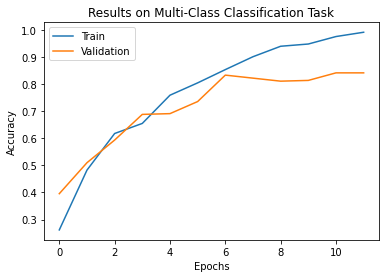

In [18]:
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Results on Multi-Class Classification Task');

In [19]:
test_img2 = img_to_array(load_img('drive/MyDrive/Capstone/SampleImages/Mixed/images-8.jpeg'))
test_img2 = smart_resize(test_img2, (256, 256))
test_img2 = np.expand_dims(test_img2, axis=0)
model2.predict(test_img2).round()

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

# Model 3

In [20]:
aug_gen = ImageDataGenerator(
    rescale=1/255,
    vertical_flip=True,
    rotation_range=20,
    validation_split = 0.2
)

train_data = aug_gen.flow_from_directory(
    'drive/MyDrive/Capstone/Images', 
    class_mode='binary',
    seed = 42,
    subset = 'training'
    )
test_data = aug_gen.flow_from_directory(
    'drive/MyDrive/Capstone/Images', 
    class_mode='binary',
    seed = 42,
    subset = 'validation'
    )

Found 1451 images belonging to 10 classes.
Found 359 images belonging to 10 classes.


In [21]:
model3 = Sequential()
model3.add(Conv2D(64, (3,3), activation = 'relu', input_shape = (256, 256, 3)))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(Conv2D(64, (3,3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(Dense(10, activation='softmax'))

model3.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1)

history3 = model3.fit(train_data, 
                    validation_data=test_data, 
                    epochs=25,
                    callbacks = early_stop
)

Epoch 1/25
46/46 [==============================] - 42s 916ms/step - loss: 2.6805 - accuracy: 0.2764 - val_loss: 1.6639 - val_accuracy: 0.4011
Epoch 2/25
46/46 [==============================] - 43s 928ms/step - loss: 1.4664 - accuracy: 0.4742 - val_loss: 1.3033 - val_accuracy: 0.5320
Epoch 3/25
46/46 [==============================] - 42s 905ms/step - loss: 1.2057 - accuracy: 0.5961 - val_loss: 1.1807 - val_accuracy: 0.5989
Epoch 4/25
46/46 [==============================] - 41s 900ms/step - loss: 1.0108 - accuracy: 0.6761 - val_loss: 0.9712 - val_accuracy: 0.6825
Epoch 5/25
46/46 [==============================] - 41s 895ms/step - loss: 0.8900 - accuracy: 0.7126 - val_loss: 0.9495 - val_accuracy: 0.6908
Epoch 6/25
46/46 [==============================] - 41s 892ms/step - loss: 0.7459 - accuracy: 0.7781 - val_loss: 0.7684 - val_accuracy: 0.7799
Epoch 7/25
46/46 [==============================] - 42s 924ms/step - loss: 0.6291 - accuracy: 0.7967 - val_loss: 0.7471 - val_accuracy: 0.7577

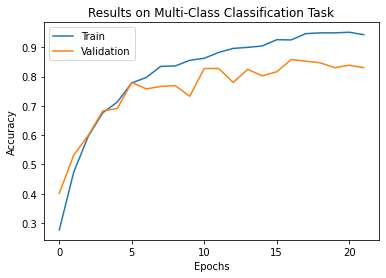

In [22]:
plt.plot(history3.history['accuracy'], label='Train')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Results on Multi-Class Classification Task');

In [23]:
test_img3 = img_to_array(load_img('drive/MyDrive/Capstone/SampleImages/Mixed/images-8.jpeg'))
test_img3 = smart_resize(test_img3, (256, 256))
test_img3 = np.expand_dims(test_img3, axis=0)
model3.predict(test_img3).round()

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Model 4

In [24]:
eff_gen = ImageDataGenerator(validation_split = 0.2)

train_data2 = eff_gen.flow_from_directory(
    'drive/MyDrive/Capstone/Images',
    class_mode='binary',
    seed = 42,
    subset = 'training',
    target_size=(224,224)    
)

test_data2 = eff_gen.flow_from_directory(
    'drive/MyDrive/Capstone/Images',
    class_mode='binary',
    seed = 42,
    subset = 'validation',
    target_size=(224, 224)
)

Found 1451 images belonging to 10 classes.
Found 359 images belonging to 10 classes.


In [25]:
effnet = EfficientNetB0(include_top=False, weights='imagenet')

16719872/16705208 [==============================] - 0s 0us/step


In [26]:
model4 = Sequential()
model4.add(effnet)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(100, activation='relu'))
model4.add(Dense(10, activation='softmax'))

model4.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1)

history4 = model4.fit(
    train_data2,
    validation_data=test_data2,
    batch_size=32,
    epochs=15,
    validation_batch_size=32,
    callbacks = early_stop
)

Epoch 1/15
46/46 [==============================] - 35s 534ms/step - loss: 0.3519 - accuracy: 0.9187 - val_loss: 0.0429 - val_accuracy: 0.9889
Epoch 2/15
46/46 [==============================] - 22s 468ms/step - loss: 0.0469 - accuracy: 0.9883 - val_loss: 0.4957 - val_accuracy: 0.8774
Epoch 3/15
46/46 [==============================] - 22s 469ms/step - loss: 0.0554 - accuracy: 0.9835 - val_loss: 0.2327 - val_accuracy: 0.9499
Epoch 4/15
46/46 [==============================] - 22s 472ms/step - loss: 0.0575 - accuracy: 0.9814 - val_loss: 0.2324 - val_accuracy: 0.9582
Epoch 5/15
46/46 [==============================] - 22s 476ms/step - loss: 0.0328 - accuracy: 0.9904 - val_loss: 0.0239 - val_accuracy: 0.9861
Epoch 6/15
46/46 [==============================] - 23s 492ms/step - loss: 0.0822 - accuracy: 0.9814 - val_loss: 0.7748 - val_accuracy: 0.8663
Epoch 7/15
46/46 [==============================] - 22s 469ms/step - loss: 0.0551 - accuracy: 0.9828 - val_loss: 0.5544 - val_accuracy: 0.9359

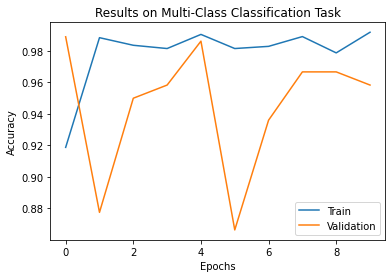

In [28]:
plt.plot(history4.history['accuracy'], label='Train')
plt.plot(history4.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Results on Multi-Class Classification Task');

In [29]:
test_img4 = img_to_array(load_img('drive/MyDrive/Capstone/SampleImages/Mixed/images-8.jpeg'))
test_img4 = smart_resize(test_img4, (256, 256))
test_img4 = np.expand_dims(test_img4, axis=0)
model4.predict(test_img4).round()

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [30]:
model4.save('drive/MyDrive/Capstone/model.h5') 

# Sources

https://github.com/keras-team/keras/issues/5862#issuecomment-647559571

https://blog.francium.tech/feature-detection-and-matching-with-opencv-5fd2394a590

https://docs.opencv.org/3.3.1/d1/d89/tutorial_py_orb.html

https://medium.com/@deepanshut041/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf

https://pyimagesearch.com/2021/04/28/opencv-color-spaces-cv2-cvtcolor/

https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

https://androidkt.com/keras-confusion-matrix-in-tensorboard/